In [1]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pathlib
from models.networks import define_G
import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Test

### load model

In [2]:
transform=transforms.Compose([transforms.Resize((512,512)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [3]:
opt = argparse.Namespace(
    input_nc=3,
    output_nc=3,
    ngf=64,
    netG='unet_256',
    norm='batch',
    use_dropout=False,
    init_type='normal',
    init_gain=0.02,
    gpu_ids=[0],
    activation='swish',
    squeeze=4
)

In [4]:
netG = define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, norm=opt.norm, use_dropout=opt.use_dropout, init_type=opt.init_type, init_gain=opt.init_gain, gpu_ids=opt.gpu_ids, activation=opt.activation,squeeze=opt.squeeze)
netG = netG.module
netG = netG.to(device)

512 512 512 128
512 512 512 128
512 512 512 128
512 512 512 128
256 512 256 64
128 256 128 32
64 128 64 16
initialize network with normal


In [5]:
model_list = sorted(list(pathlib.Path('./checkpoints/ffhq_disney_512_pix2pix').glob('*_G.pth')))
model_list = model_list[:-1]
model_list = sorted(model_list,key=lambda x:int(x.name.split('_')[0]))

### img_test

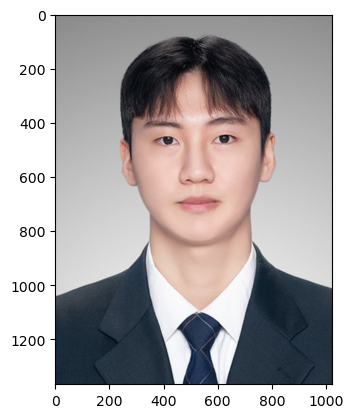

In [6]:
img = Image.open('./test_img/face_img.jpeg').convert('RGB')
plt.imshow(img)

In [8]:
t_img = transform(img)
t_img=t_img.view(1,3,512,512)
t_img = t_img.to(device)

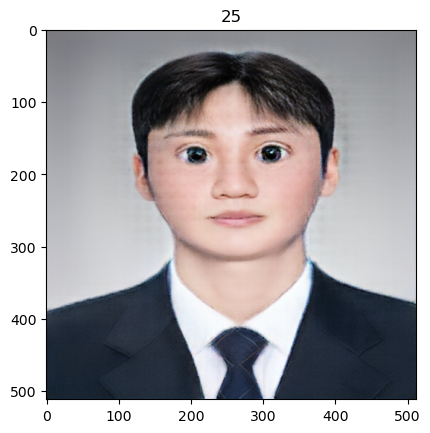

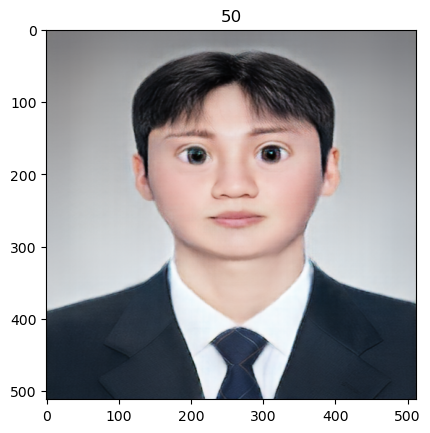

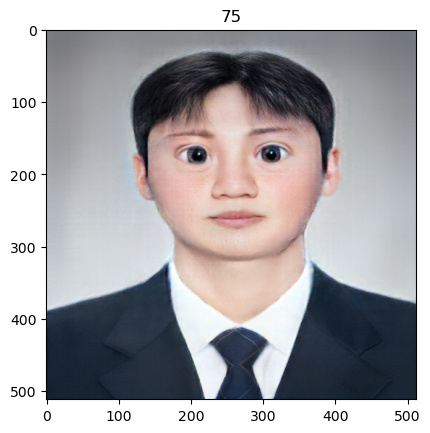

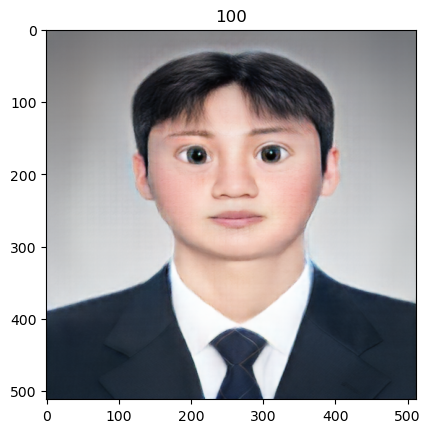

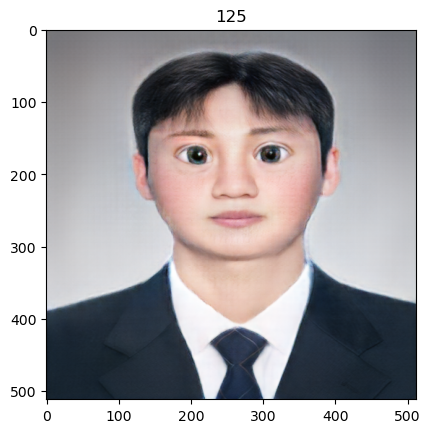

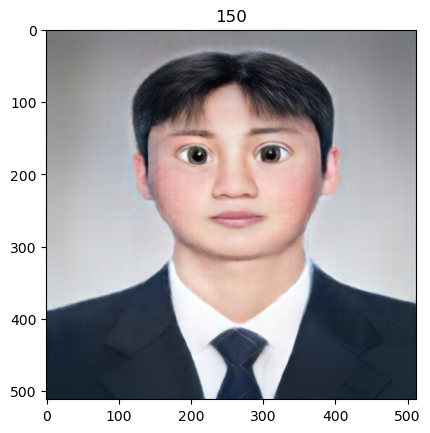

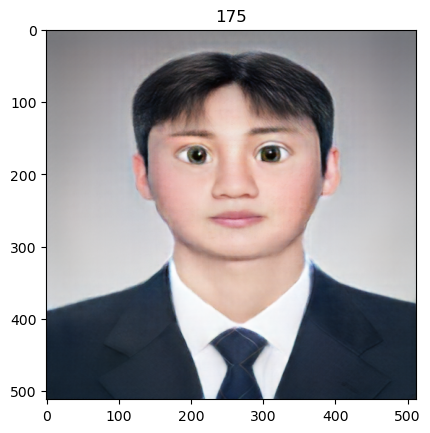

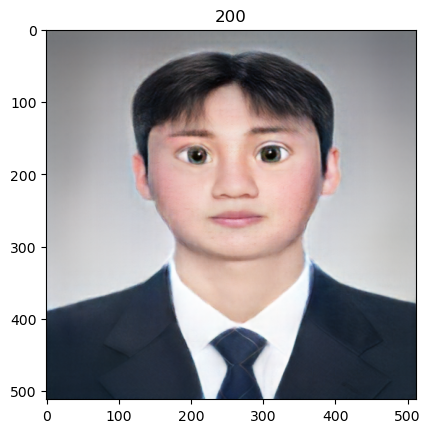

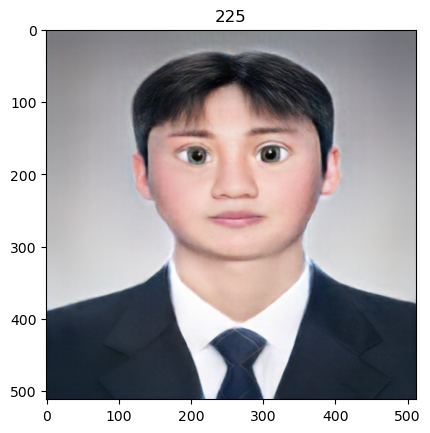

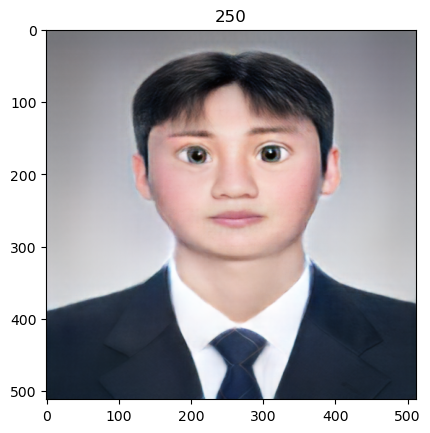

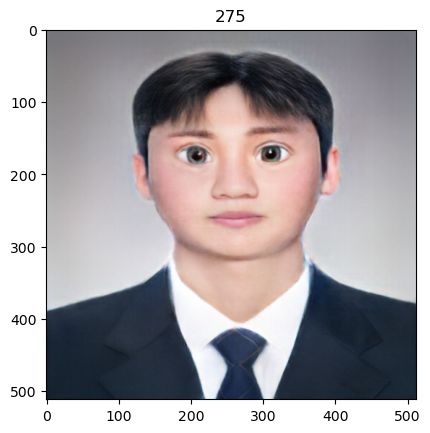

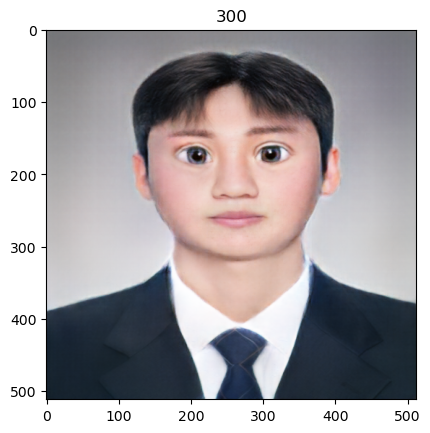

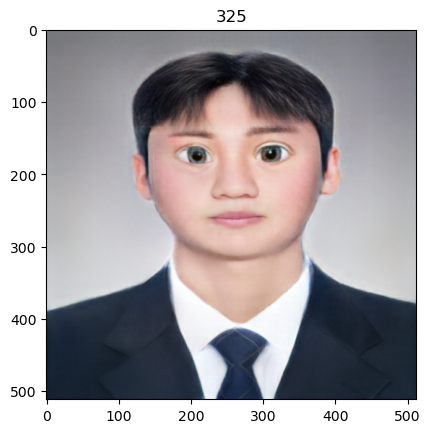

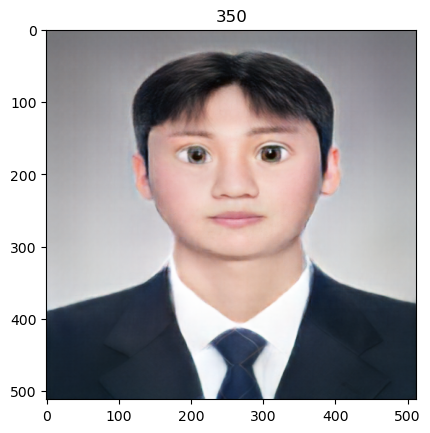

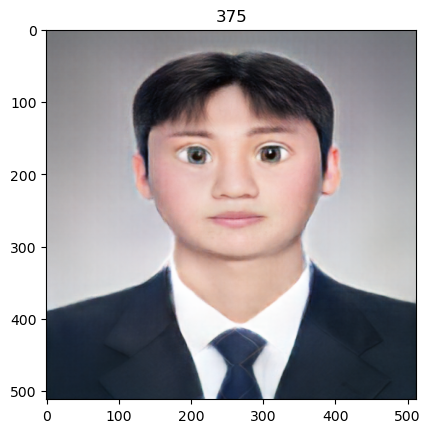

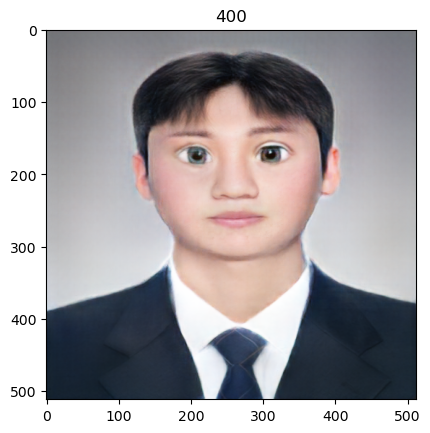

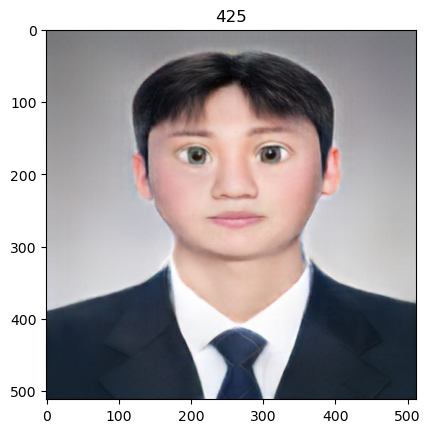

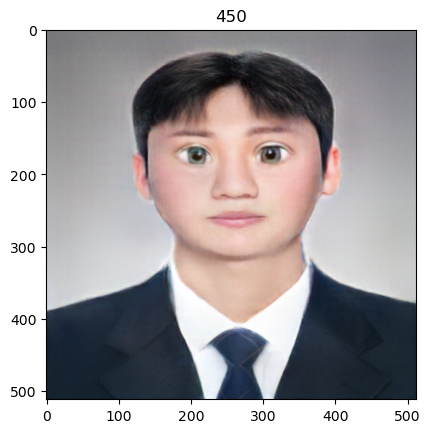

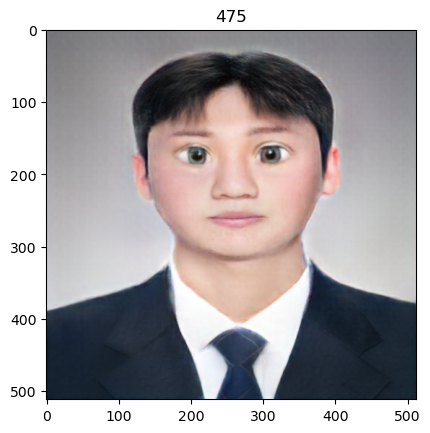

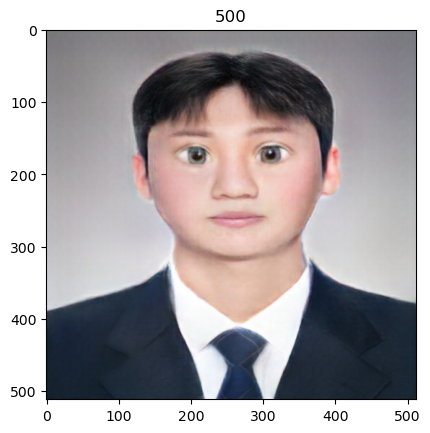

In [9]:
for params in model_list:
    netG.load_state_dict(torch.load(params))
    netG.eval()
    with torch.no_grad():
        out=netG(t_img)
    out=out.to('cpu')
    out=out*0.5+0.5
    plt.imshow(out[0].permute(1,2,0))
    plt.title(params.name.split('_')[0])
    plt.show()

### video_test

In [ ]:
opt = argparse.Namespace(
    batch_size=4,
    input_nc=3,
    output_nc=3,
    ngf=64,
    netG='unet_256',
    norm='batch',
    use_dropout=False,
    init_type='normal',
    init_gain=0.02,
    gpu_ids=[],
    activation='swish',
    squeeze=4,
    gan_mode='lsgan'
)

netG = define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, norm=opt.norm, use_dropout=opt.use_dropout, init_type=opt.init_type, init_gain=opt.init_gain, gpu_ids=opt.gpu_ids, activation=opt.activation,squeeze=opt.squeeze)

netG.load_state_dict(torch.load('./checkpoints/ffhq_disney_512_pix2pix/latest_net_G.pth'))
netG = netG.to(device)
netG.eval()

In [ ]:
import cv2

cap = cv2.VideoCapture(0, apiPreference=None)
cap.isOpened()
#check camera is available

In [ ]:
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width,height

crop = max(width,height)
transform = transforms.Compose([transforms.CenterCrop((crop//2,crop//2)),transforms.Resize((512,512)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
#Centor crop because of transformation quality

In [ ]:
if cap.isOpened():
    while True:
        ret,img = cap.read()
        if ret:
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img,mode='RGB')
            t_img = transform(img)
            t_img=t_img.view(1,3,512,512)
            with torch.no_grad():
                out = netG(t_img)
            out = np.transpose(out.numpy()[0],(1,2,0))
            out=out*0.5+0.5
            out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB) # RGB 채널
            #out = out.astype(np.uint8).copy()
            
            cv2.imshow('camera', out)
            if cv2.waitKey(1) != -1: # 지정된 시간동안 키입력이 없으면 -1을 계속 반환
                break
        else:
            print('no frame!')
            break
else:
    print('can`t open camera!')
cap.release()
cv2.destroyAllWindows()